In [1]:
import torch
import torchvision.transforms as transforms              
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader

# load pre-trained model InceptionV3 and set mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

#  Reprocess: Center Crop and then resize to 299*299
data_transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Resize(256), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

sorted_val_path = "D:\\Download\\ImageNet-1K\\Validation_Set\\sorted_ImageNet_val"
dataset = ImageFolder(root=sorted_val_path, transform=data_transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

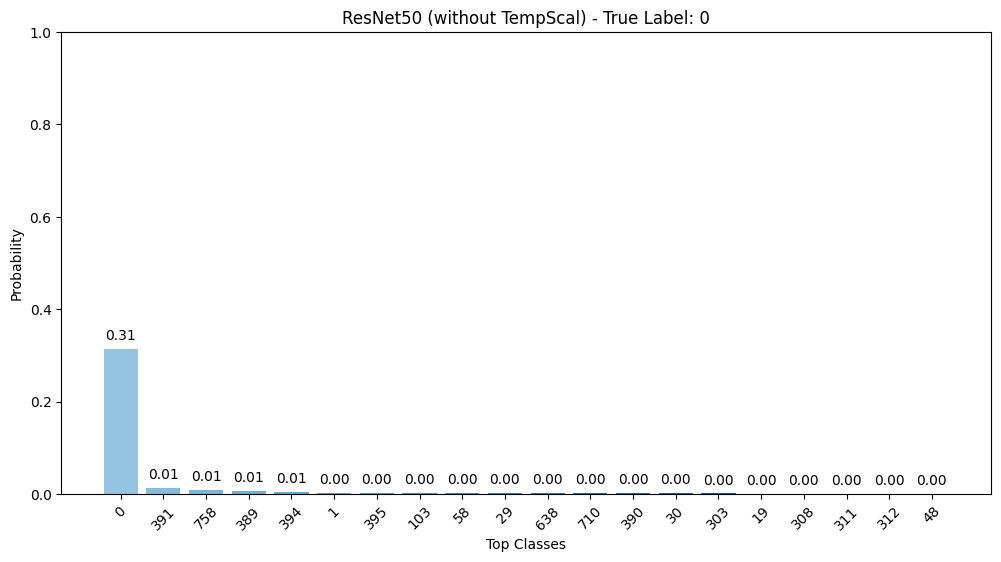

In [2]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

test_iter = iter(test_loader)
image, label = next(test_iter)
image, label = image[1].to(device), label[1].item()
model.eval()

with torch.no_grad():
    logits = model(image.unsqueeze(0))  
    probabilities = F.softmax(logits, dim=1).cpu().numpy().flatten() 

num_classes = 1000
top_k = 20 

top_indices = np.argsort(probabilities)[-top_k:][::-1]
top_probs = probabilities[top_indices]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(top_k), top_probs, color=plt.cm.Blues(np.linspace(0.4, 1, top_k)))

plt.xlabel("Top Classes")
plt.ylabel("Probability")
plt.title(f"ResNet50 (without TempScal) - True Label: {label}")
plt.ylim(0, 1)
plt.xticks(range(top_k), top_indices, rotation=45) 

for bar, prob in zip(bars, top_probs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f"{prob:.2f}", ha='center', fontsize=10)

plt.show()

Before temperature - NLL: 2.092, ECE: 0.533
Optimal temperature: 0.705
After temperature - NLL: 1.189, ECE: 0.157


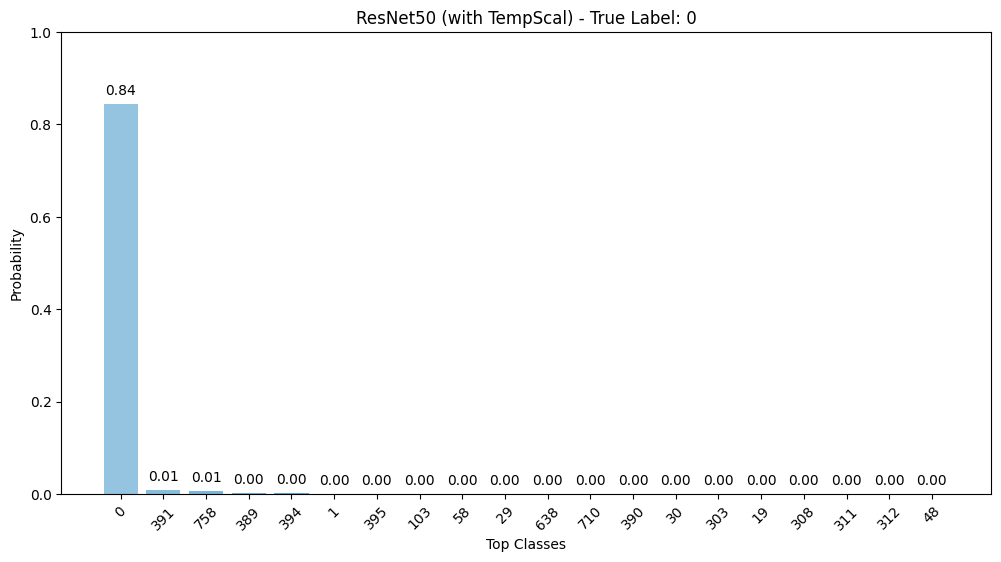

In [7]:
from src.temperature_scaling import ModelWithTemperature
from torch.utils.data import Subset

# take 1/10 of ImageNet-1k 
subset_size = len(dataset) // 10
indices = np.random.choice(len(dataset), subset_size, replace=False)
subset_dataset = Subset(dataset, indices)
train_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False, num_workers=2)

model_with_temp = ModelWithTemperature(model, temperature = 1.0).to(device)
model_with_temp.set_temperature(train_loader)
model_with_temp.eval()

with torch.no_grad():
    logits = model_with_temp(image.unsqueeze(0))  
    probabilities_temp = F.softmax(logits, dim=1).cpu().numpy().flatten() 

num_classes = 1000
top_k = 20 

top_indices = np.argsort(probabilities_temp)[-top_k:][::-1]
top_probs = probabilities_temp[top_indices]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(top_k), top_probs, color=plt.cm.Blues(np.linspace(0.4, 1, top_k)))

plt.xlabel("Top Classes")
plt.ylabel("Probability")
plt.title(f"ResNet50 (with TempScal) - True Label: {label}")
plt.ylim(0, 1)
plt.xticks(range(top_k), top_indices, rotation=45) 

for bar, prob in zip(bars, top_probs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f"{prob:.2f}", ha='center', fontsize=10)

plt.show()